In [1]:
#import quandl
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)
import sklearn.datasets
import pandas as pd
from sklearn import preprocessing

backwards_points = 75

In [3]:
DJIA_data = pd.read_csv("DJIA_single_feature.csv")
DJIA_data["Date"] = pd.to_datetime(DJIA_data.Date)
DJIA_data.head()

,Date,Close
0,2016-07-01,17949.36914
1,2016-06-30,17929.99023
2,2016-06-29,17694.67969
3,2016-06-28,17409.72070
4,2016-06-27,17140.24023


In [4]:
plot_test = pd.DataFrame(DJIA_data)
plot_test = plot_test.sort_values(by="Date", ascending=True)
plot_test["Time (Days)"] = np.arange(len(plot_test))
plot_test = plot_test.drop("Date", axis = 1)
plot_test.head()

,Close,Time (Days)
1988,11734.32031,0
1987,11782.34961,1
1986,11642.46973,2
1985,11532.95996,3
1984,11615.92969,4


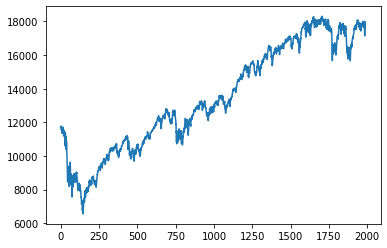

In [5]:
plt.plot(plot_test["Time (Days)"], plot_test["Close"], label='DJIA')

In [6]:
def convert_data(DJIA_data):
    DJIA_df = pd.DataFrame(DJIA_data)
    DJIA_df = DJIA_df.sort_values(by="Date", ascending=True)
    DJIA_df = DJIA_df.drop("Date", axis = 1)
    DJIA_df = DJIA_df.values

    DJIA_df_normaliser = preprocessing.MinMaxScaler()
    DJIA_df_normalised = DJIA_df_normaliser.fit_transform(DJIA_df)
    past_values_normalised =  np.array([DJIA_df_normalised[i:i + backwards_points].copy() for i in range(len(DJIA_df_normalised) - backwards_points)])
    next_day_values_normalised =  np.array([DJIA_df_normalised[:,0][i + backwards_points].copy() for i in range(len(DJIA_df_normalised) - backwards_points)])
    next_day_values_normalised = np.expand_dims(next_day_values_normalised, -1)

    next_day_values = np.array([DJIA_df[:,0][i + backwards_points].copy() for i in range(len(DJIA_df) - backwards_points)])
    next_day_values = np.expand_dims(next_day_values, -1)
    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_values)

    return past_values_normalised, next_day_values_normalised, next_day_values, y_normaliser

In [7]:
past_values, next_day_values, y_no_mod, y_normaliser = convert_data(DJIA_data)

test_split = 0.8
n = int(past_values.shape[0] * test_split)

X_train = past_values[:n]
y_train = next_day_values[:n]
X_test = past_values[n:]
y_test = next_day_values[n:]

y_no_mod_test = y_no_mod[n:]

print(X_train.shape)
print(X_test.shape)

(1531, 75, 1)
(383, 75, 1)


In [8]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers

#https://keras.io/api/layers/recurrent_layers/lstm/
lstm_input = Input(shape = (backwards_points, 1))
x = LSTM(75)(lstm_input)
x = Dropout(0.21)(x)
x = Dense(64)(x)
x = Activation("sigmoid")(x)
x = Dense(1)(x)
output = Activation("linear")(x)

model = Model(inputs=lstm_input, outputs=output)
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.2)
print(model.summary())

Using TensorFlow backend.


Train on 1224 samples, validate on 307 samples
Epoch 1/50
1224/1224 [==============================] - 4s 3ms/step - loss: 0.2467 - val_loss: 0.0482
Epoch 2/50
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0094 - val_loss: 0.0366
Epoch 3/50
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0042 - val_loss: 0.0090
Epoch 4/50
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 5/50
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 6.1773e-04
Epoch 6/50
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0019 - val_loss: 5.7997e-04
Epoch 7/50
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 5.9005e-04
Epoch 8/50
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 9/50
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 7.5788e-04
Epoch 10/50
1224/12

In [9]:
y_test_predicted = model.predict(X_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(past_values)
y_predicted = y_normaliser.inverse_transform(y_predicted)

#https://www.geeksforgeeks.org/python-mean-squared-error/
MSE = np.square(np.subtract(y_no_mod_test, y_test_predicted)).mean() 
returned_mse = MSE / (np.max(y_no_mod_test) - np.min(y_no_mod_test)) * 100
print(returned_mse)

8819.330479704537


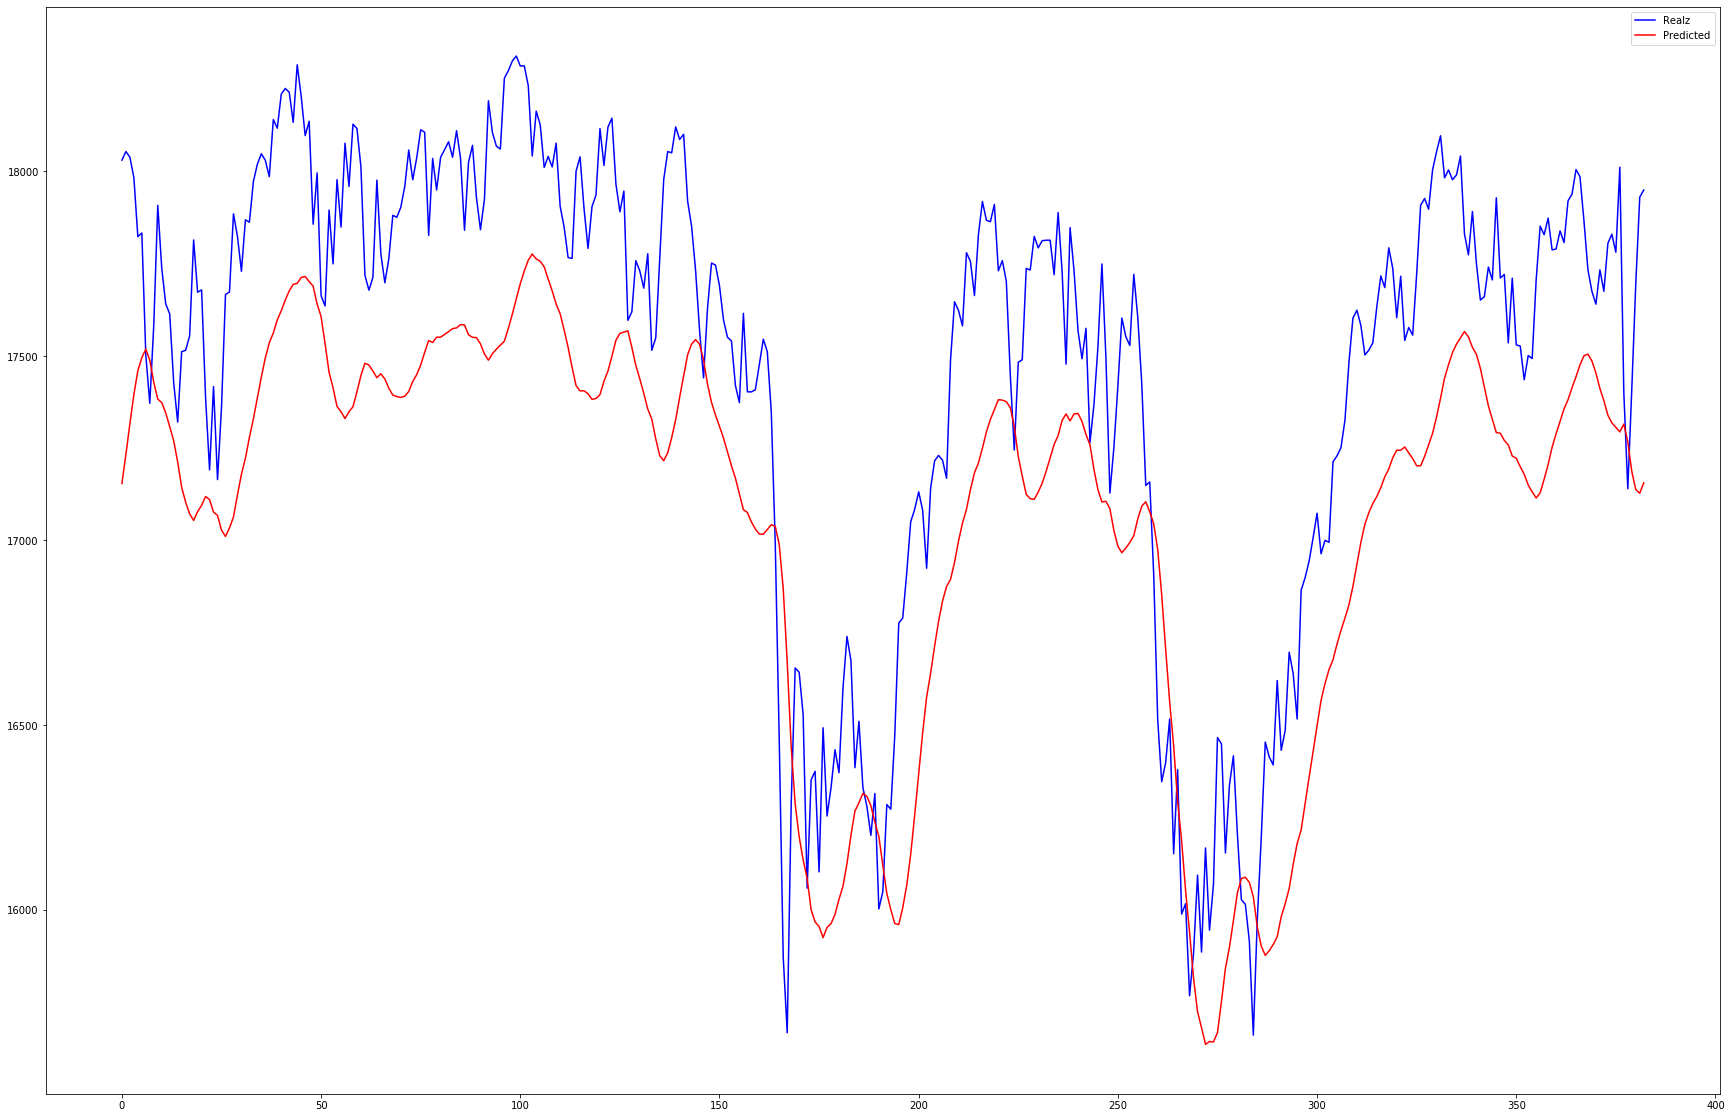

In [10]:
#plt.gcf is get current figure
plt.gcf().set_size_inches(30, 20, forward=True)
plt.plot(y_no_mod_test, label="Real", color="blue")
plt.plot(y_test_predicted, label="Prediction", color="red")
plt.legend(["Realz", "Predicted"])

plt.show()

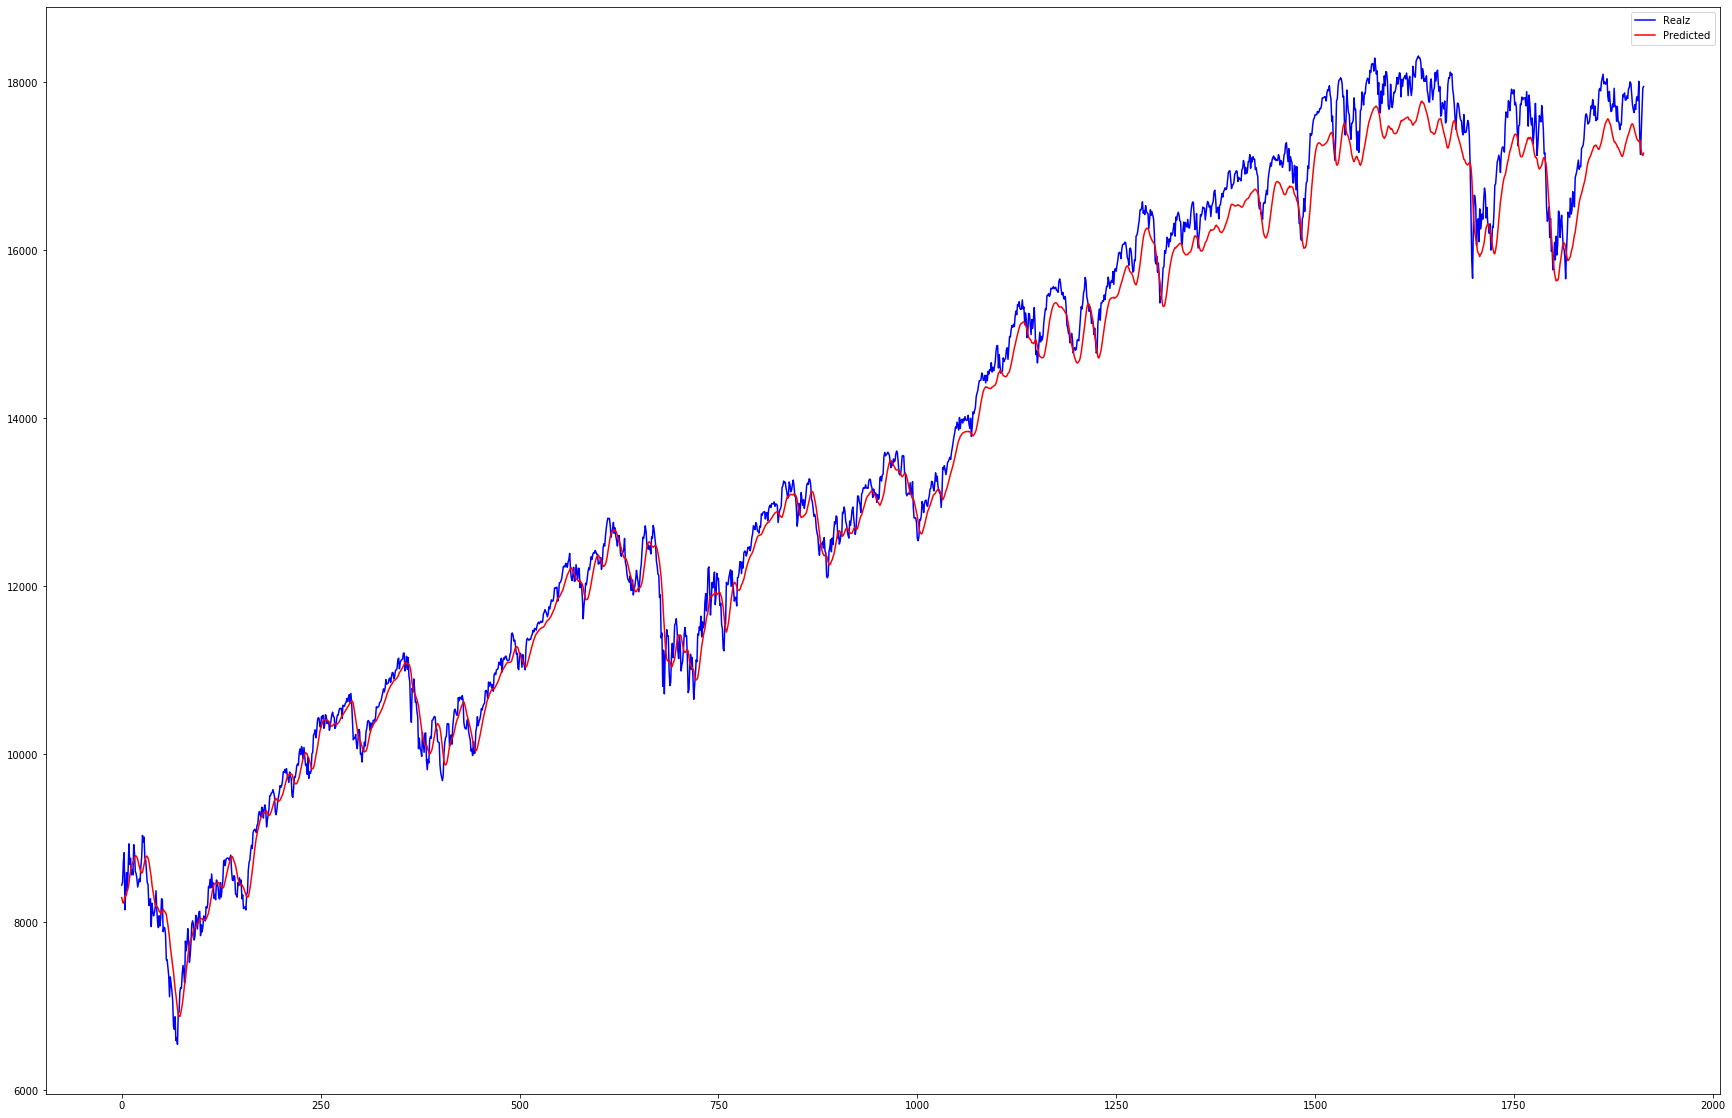

In [13]:
plt.gcf().set_size_inches(30, 20, forward=True)
plt.plot(y_no_mod, label="Real", color="blue")
plt.plot(y_predicted, label="Prediction", color="red")
plt.legend(["Realz", "Predicted"])

plt.show()